# t-SNE Preprocessing Comparison

Preprocessing data for t-SNE using PCA versus a convolutional autoencoder.

My interpretation is that PCA performs better as a pre-processing step in this case than t-SNE. This is based on the way the 2d embedding looks, but also by the k-nearest neighbors classification for different values of k. PCA provides ~96% accuracy for the 1-nearest neighbor while the convolutional autoencoder is closer to ~92% (and decreases faster).

## Notes on t-SNE implementations

This notebook uses [bhtsne](https://github.com/lvdmaaten/bhtsne) by the Laurens van der Maaten, via the Python wrapper, which is the fastest and most bug-free implementation I've found of t-SNE.

* The sklearn t-SNE implementation has [lots of issues](https://github.com/scikit-learn/scikit-learn/issues?utf8=%E2%9C%93&q=is%3Aissue+is%3Aopen+tsne) including poor performance and bad default values.
* The package installed by `pip install tsne` does not return t-SNE correctly [for three dimensions](https://github.com/danielfrg/tsne/issues/11).

Unfortunately this means I've compiled it for my system only (OSX 10.11). For other systems you will need to recompile the binary following the instructions in Laurens' repo.

In [20]:
plot_size = (2048, 2048)
plot_skip = 4
point_size = 2
limit = None # for testing with fewer samples

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from utils import bh_tsne, plot_images, show_array
from keras.datasets import mnist
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 75.0% of memory, CuDNN 4007)


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

x_train = x_train[:limit]
y_train = y_train[:limit]
x_test = x_test[:limit]
y_test = y_test[:limit]

In [4]:
x_train_copy = np.copy(x_train) # copy data to avoid modifying it
results_pca = bh_tsne(x_train_copy.reshape(len(x_train), -1),
                      no_dims=2,
                      perplexity=30,
                      theta=0.5,
                      use_pca=True,
                      initial_dims=128)
results_pca = np.asarray(list(results_pca))

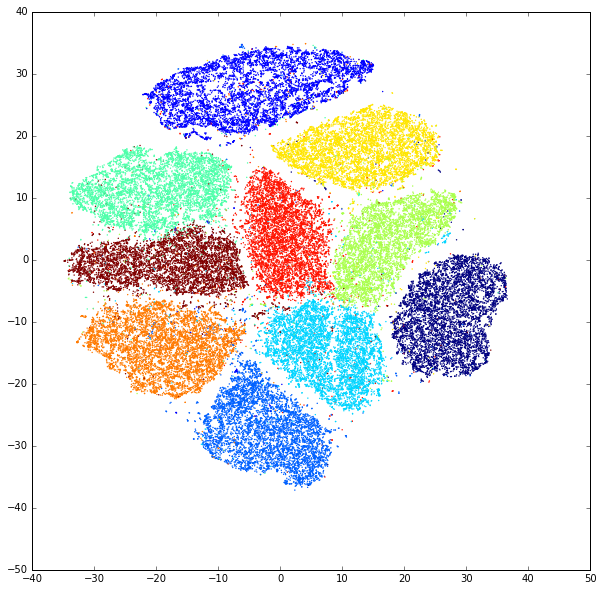

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(results_pca[:,0], results_pca[:,1], s=point_size, edgecolor='', c=y_train)
plt.show()

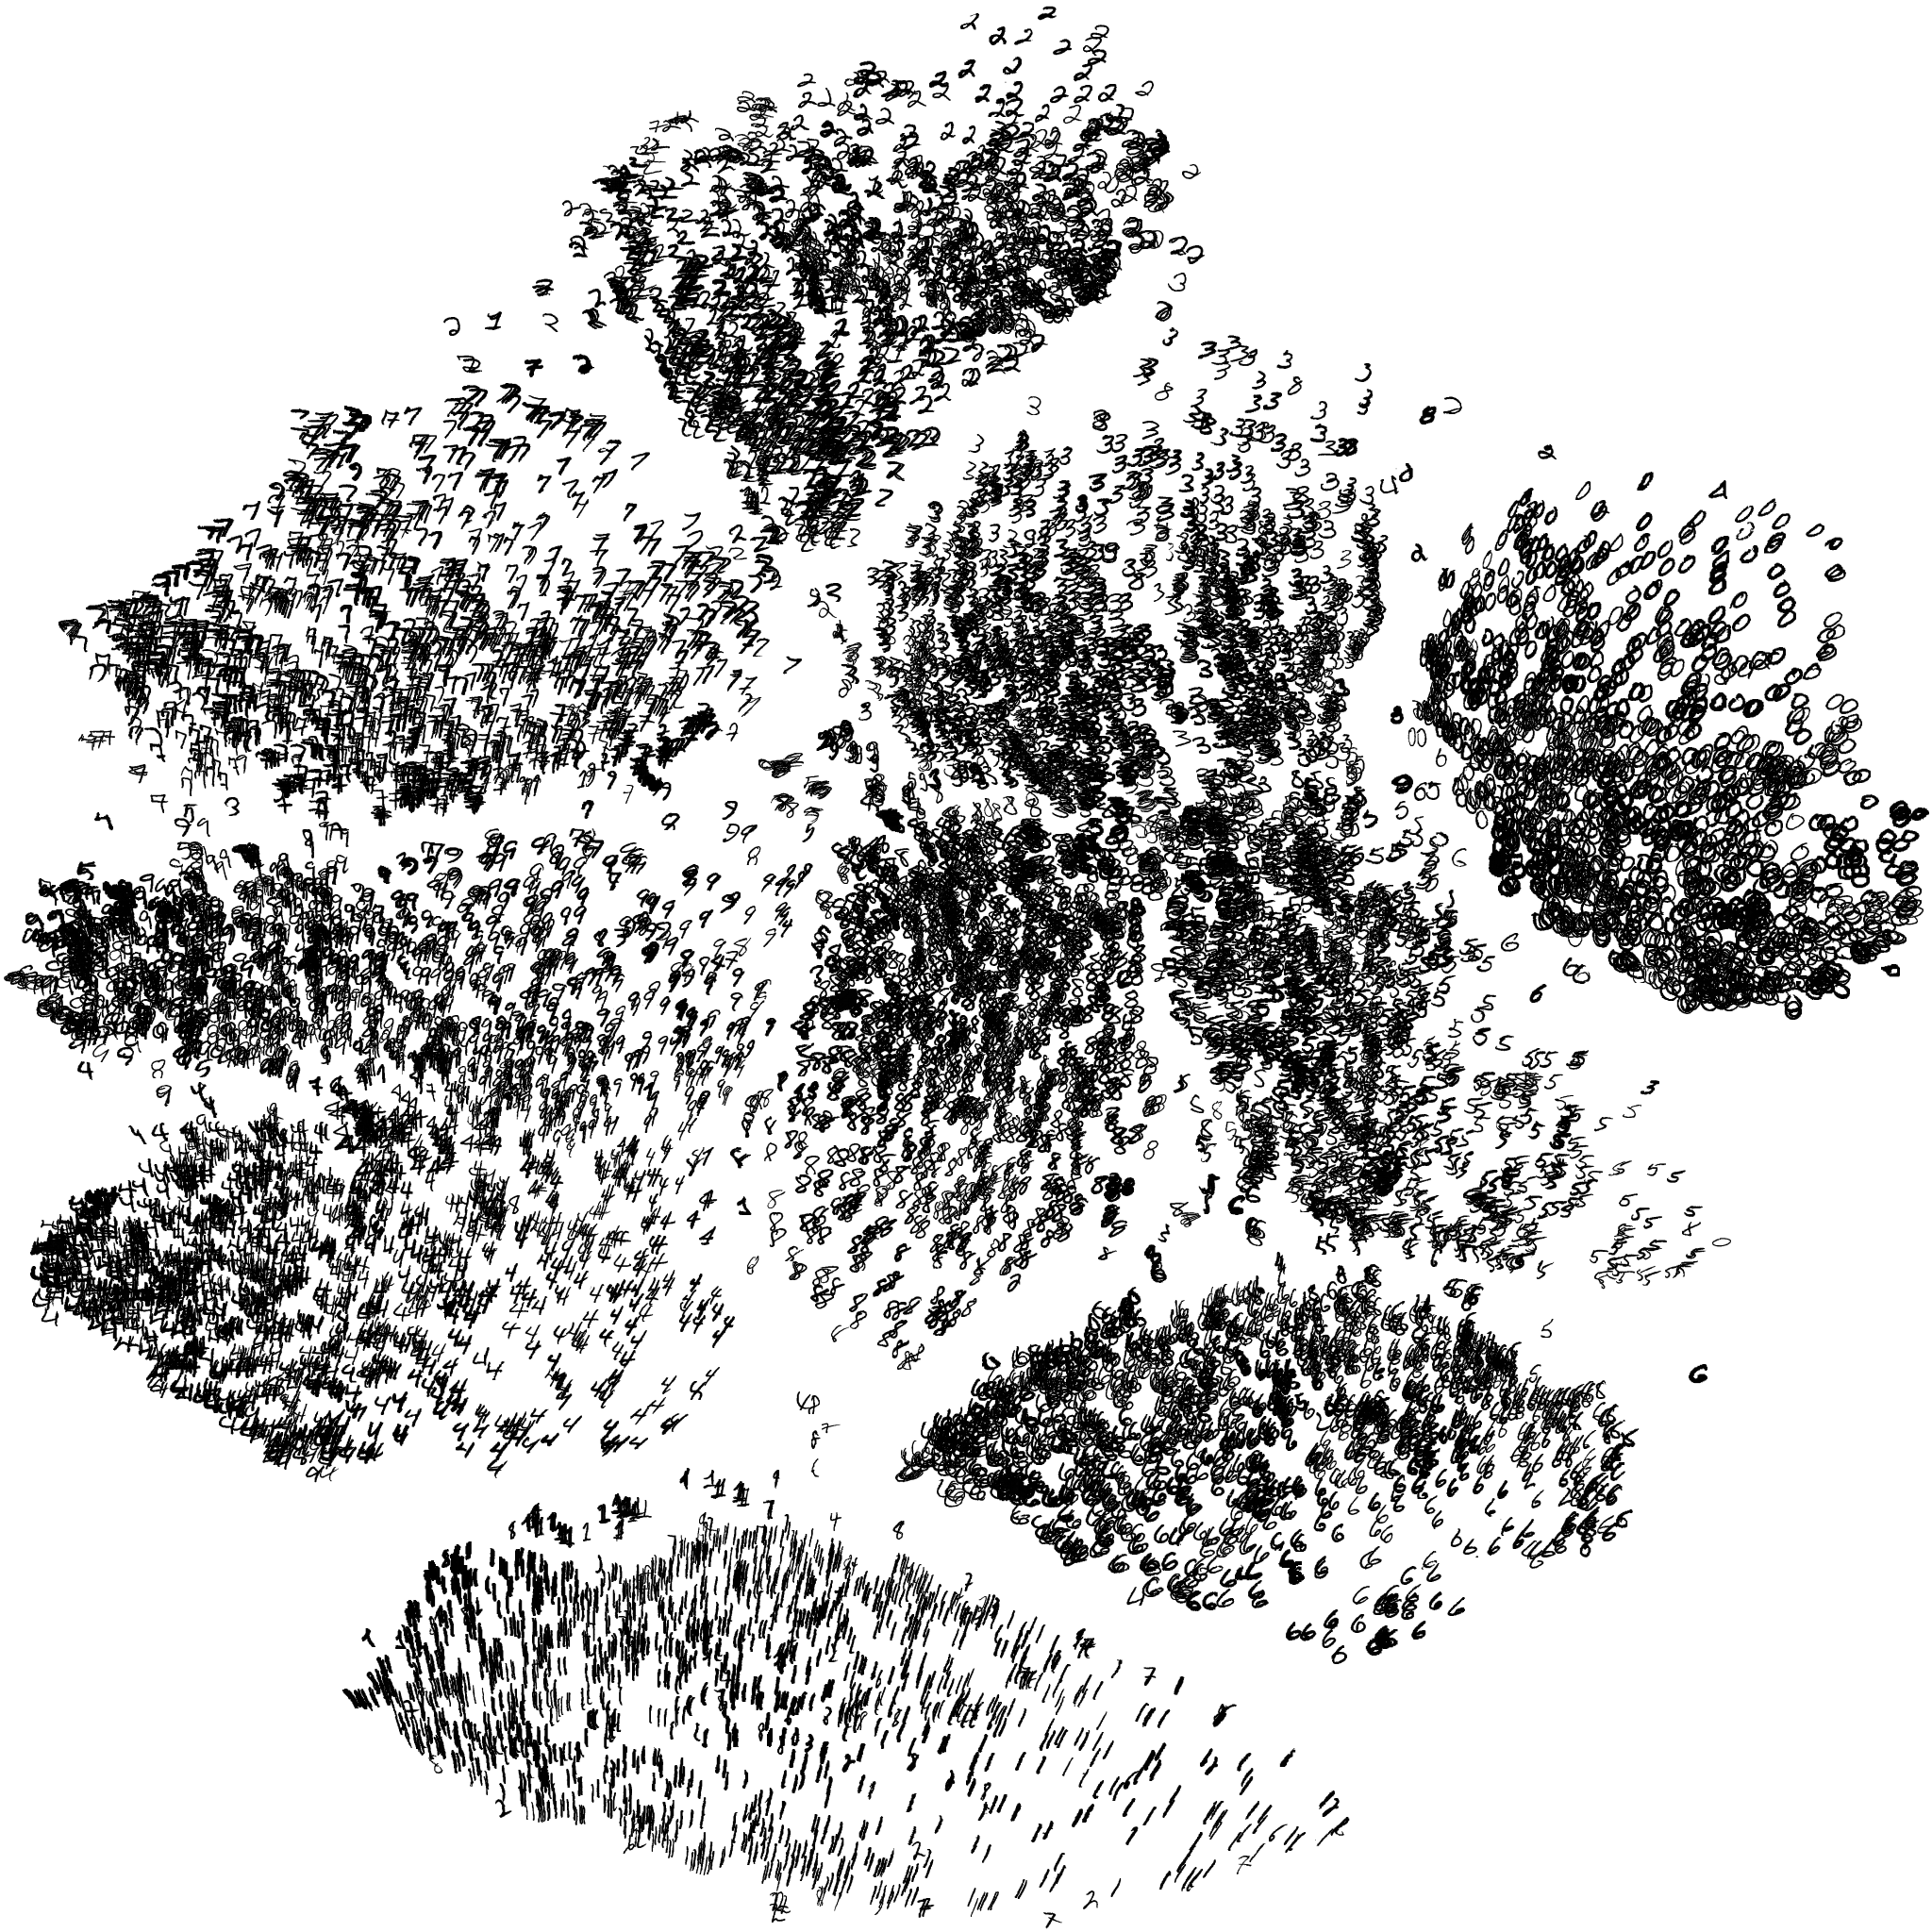

In [22]:
plotted = plot_images(x_train.reshape(len(x_train), -1)[::plot_skip],
                      results_pca[::plot_skip], figsize=plot_size, blend=np.maximum)
show_array(255 * (1 - plotted))

In [7]:
input_img = Input(shape=(1, 28, 28))

x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 3, 3, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
autoencoder.fit(x_train, x_train,
                verbose=2,
                nb_epoch=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
44s - loss: 0.2427 - val_loss: 0.1996
Epoch 2/50
42s - loss: 0.1820 - val_loss: 0.1689
Epoch 3/50
42s - loss: 0.1629 - val_loss: 0.1576
Epoch 4/50
43s - loss: 0.1514 - val_loss: 0.1452
Epoch 5/50
43s - loss: 0.1440 - val_loss: 0.1424
Epoch 6/50
44s - loss: 0.1385 - val_loss: 0.1359
Epoch 7/50
43s - loss: 0.1341 - val_loss: 0.1324
Epoch 8/50
42s - loss: 0.1309 - val_loss: 0.1310
Epoch 9/50
43s - loss: 0.1283 - val_loss: 0.1256
Epoch 10/50
43s - loss: 0.1263 - val_loss: 0.1271
Epoch 11/50
43s - loss: 0.1244 - val_loss: 0.1218
Epoch 12/50
42s - loss: 0.1227 - val_loss: 0.1192
Epoch 13/50
43s - loss: 0.1215 - val_loss: 0.1186
Epoch 14/50
43s - loss: 0.1199 - val_loss: 0.1171
Epoch 15/50
43s - loss: 0.1188 - val_loss: 0.1178
Epoch 16/50
43s - loss: 0.1180 - val_loss: 0.1166
Epoch 17/50
43s - loss: 0.1167 - val_loss: 0.1146
Epoch 18/50
43s - loss: 0.1161 - val_loss: 0.1139
Epoch 19/50
43s - loss: 0.1150 - val_loss: 0.1146
Epoch 20/

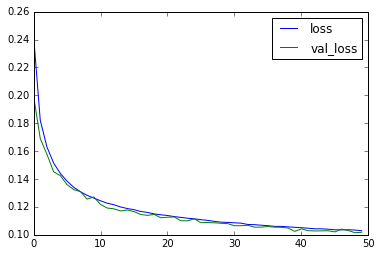

In [9]:
for metric in ['loss', 'val_loss']:
    plt.plot(autoencoder.history.history[metric], label=metric)
plt.legend()
plt.show()

In [10]:
encoder = Model(input=input_img, output=encoded)
x_encoded = encoder.predict(x_train)

In [11]:
results_cae = bh_tsne(x_encoded.reshape(len(x_encoded), -1),
                      no_dims=2,
                      perplexity=30,
                      theta=0.5,
                      use_pca=False)
results_cae = np.asarray(list(results_cae))

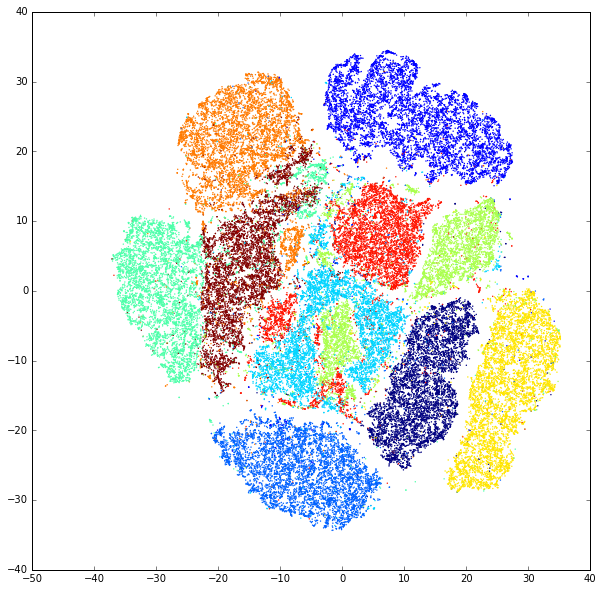

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(results_cae[:,0], results_cae[:,1], s=point_size, edgecolor='', c=y_train)
plt.show()

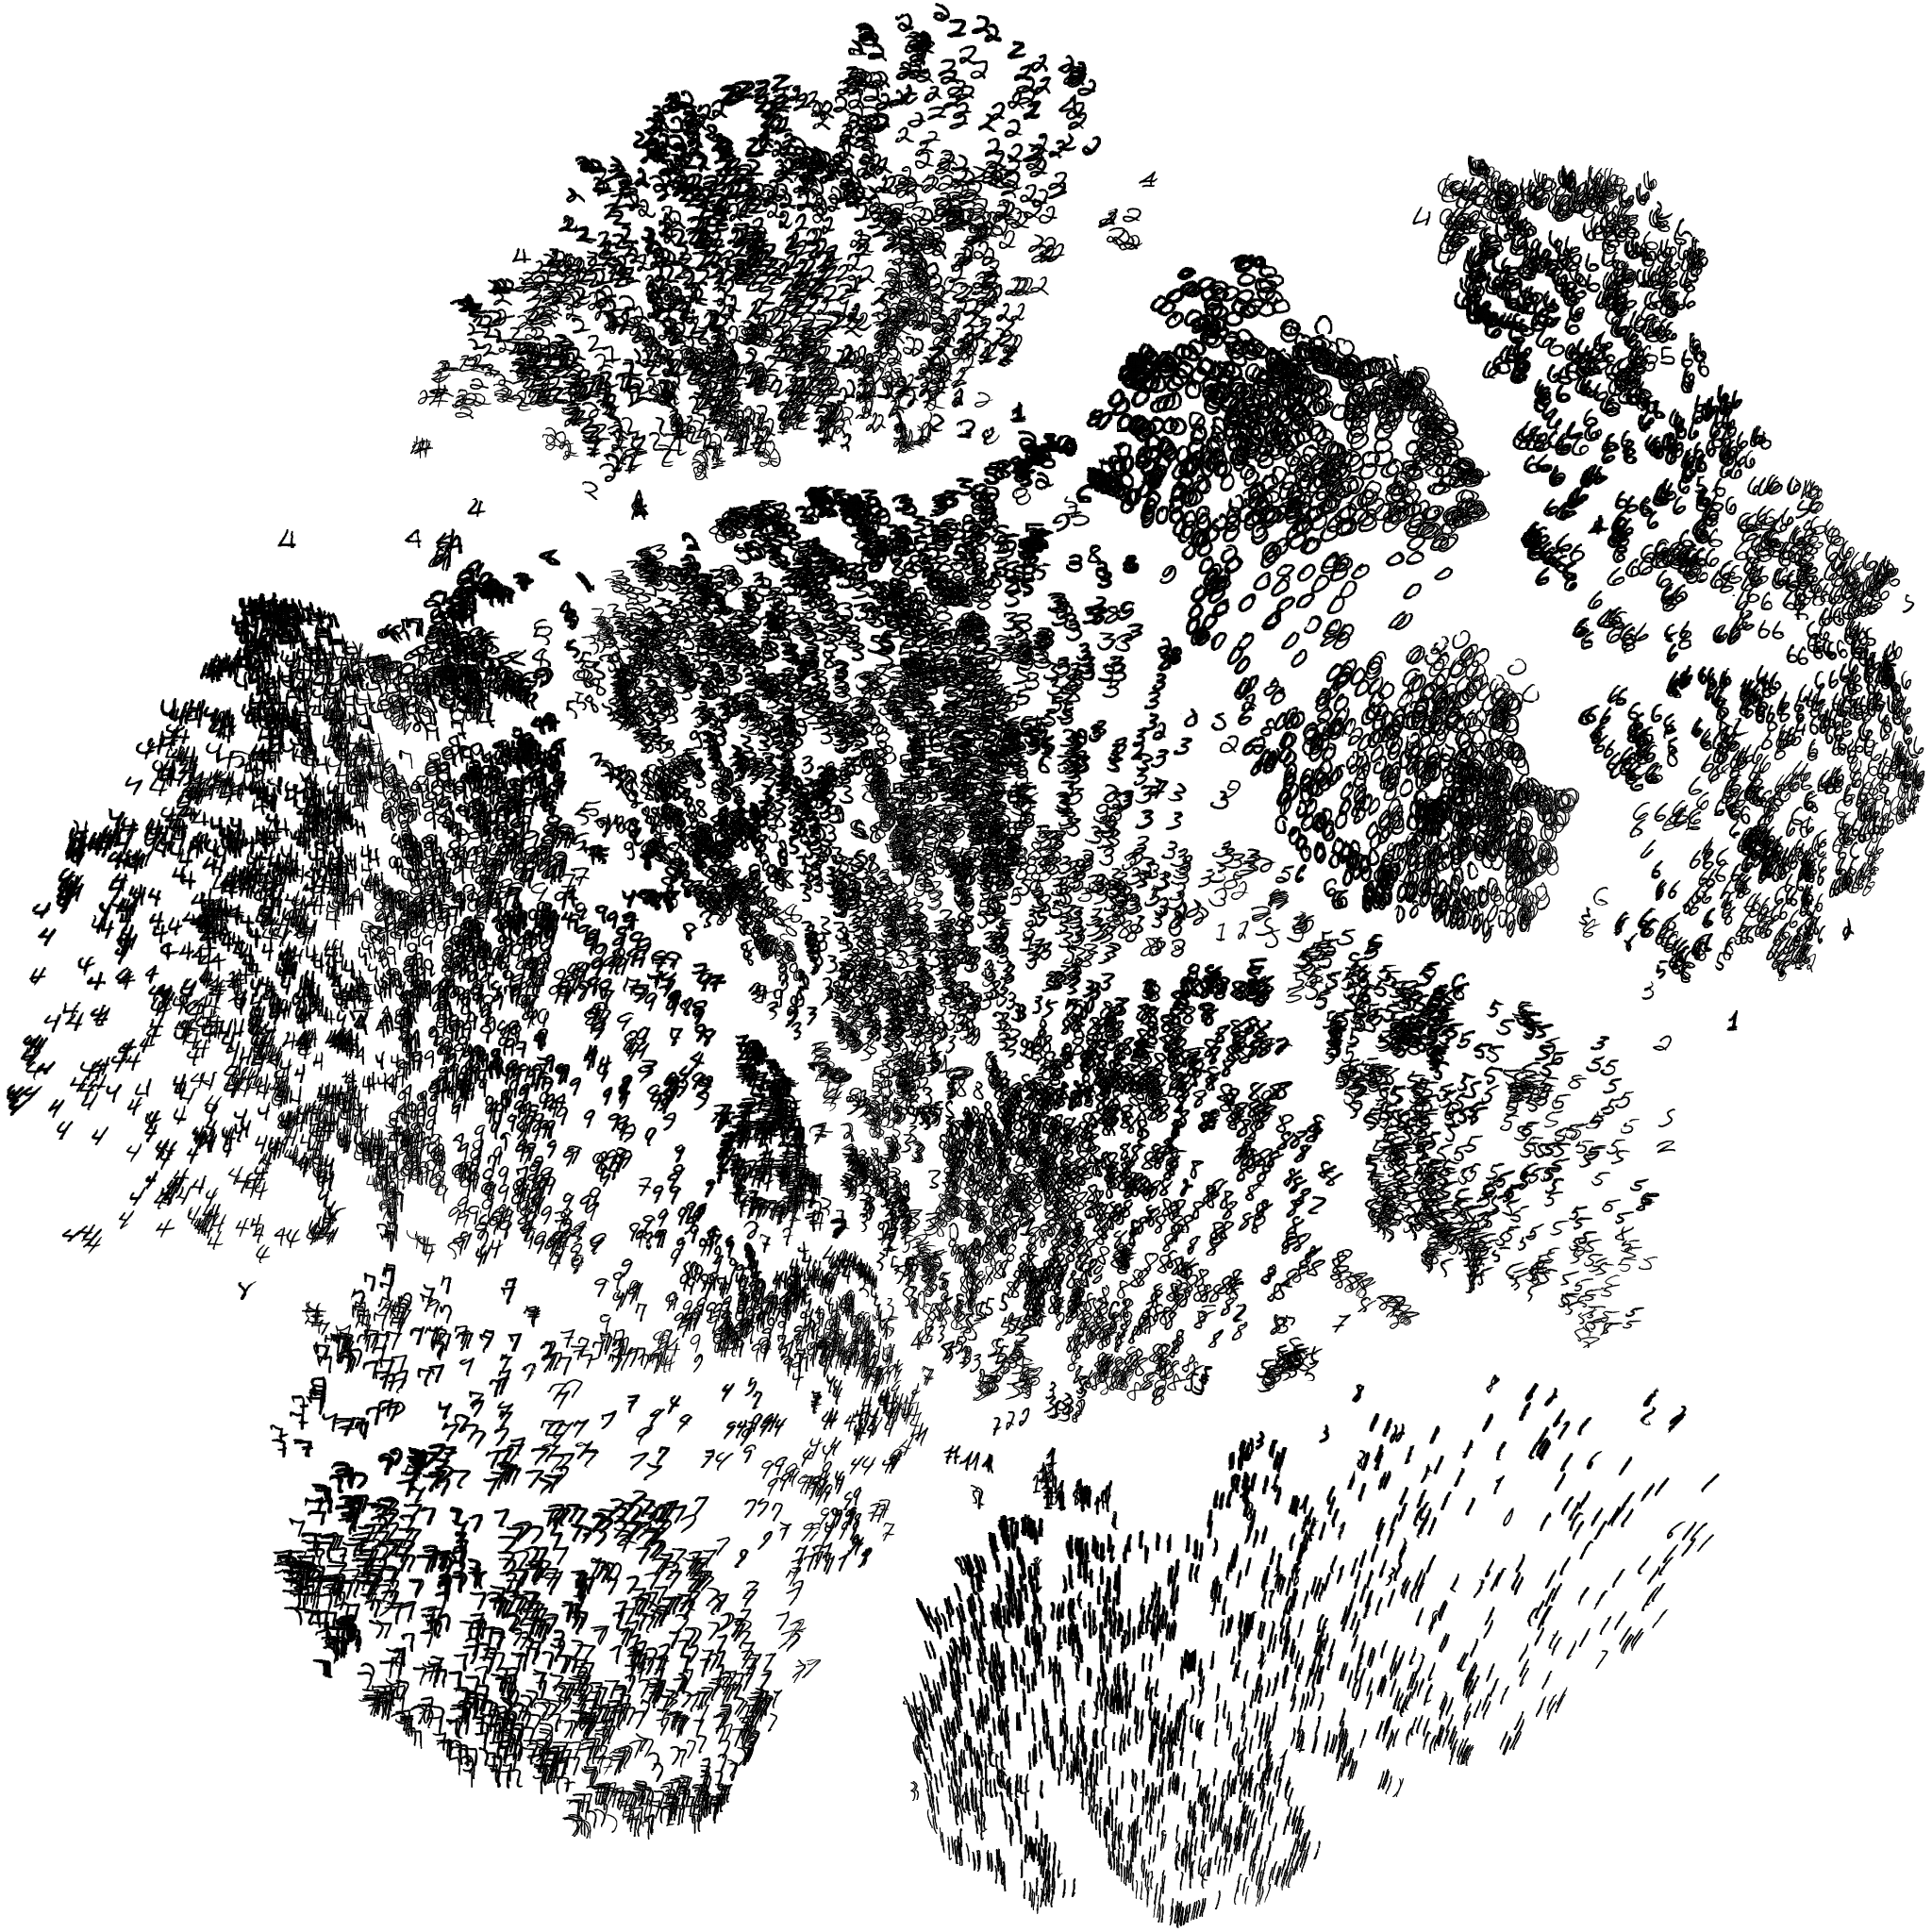

In [23]:
plotted = plot_images(x_train.reshape(len(x_train), -1)[::plot_skip],
                      results_cae[::plot_skip], figsize=plot_size, blend=np.maximum)
show_array(255 * (1 - plotted))

In [14]:
from sklearn.neighbors import BallTree
def get_knn_accuracy(x, labels, k=64):
    knn = BallTree(x)
    d, i = knn.query(x, k=k)
    nearest_labels = labels[i]
    # faster version would use as_strided
    matches = labels.repeat(k, axis=0).reshape(len(x), -1) == nearest_labels
    return matches.sum(axis=0) / float(len(x_train))

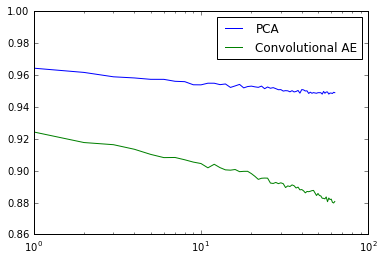

In [15]:
plt.plot(get_knn_accuracy(results_pca, y_train), label='PCA')
plt.plot(get_knn_accuracy(results_cae, y_train), label='Convolutional AE')
plt.xscale('log')
plt.legend()
plt.show()